# Visual Recognition HW1 - Semantic segmentation

## Overview
The goal of this task is to finish the implementation of a semantic segmentation model based on the [BiFPN](https://arxiv.org/abs/1911.09070) approach.
And test the capabilities of the model on [VOC 2011 dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2011/index.html).

To be more precise the model will input a batch of RGB images of shape `(BATCH, 3, IMAGE_HEIGHT, IMAGE_WIDTH)` and output a segmentation mask `m` of shape `(BATCH, #CLASS, PREDICTION_HEIGHT, PREDICTION_WIDTH)`, where `#CLASS` is the number of classes in the VOC2011 segmentation dataset.  
The mask will be such that
* `m[:, i]` equals 1, whether the element of the image corresponds to the object of the `i`-th class in the VOC 2011 segmentation dataset,

This notebook is divided into several sections:
* Preparation - 0 points (everything is already implemented)
  * Installation and imports of packages
  * code for preparation of the dataset
  * utils for visualization
* Model implementation - 2 points

* Training and evaluation - 3 points
  * metrics - 1 point
  * eval loop - 1 points
  * train loop - 1 point
* Inspection and Ablations - 5 points
  * finding best and worst predictions 2 points,
  * ablations - 3 points,


## General information
Please write the code within
```python
## TODO {

## }
```
blocks.
Please do not modify other parts of the code.

## Preparation - 0 points

### Libraries

In [ ]:
# A package for visualizing the architecture of the model
!pip install torchinfo

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchinfo
from typing import List, Optional, Tuple

### Dataset

In [ ]:
# We downscale images to
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# We will make predictions in a smaller scale
PREDICTION_HEIGHT = 64
PREDICTION_WIDTH = 64


# We want to match data distribution
# of the backbone that we will introduce later
image_net_mean = [0.485, 0.456, 0.406]
image_net_std = [0.229, 0.224, 0.225]

input_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        torchvision.transforms.ToTensor(),  # our input is an image
        torchvision.transforms.Normalize(image_net_mean, image_net_std),
    ]
)

target_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(
            (PREDICTION_HEIGHT, PREDICTION_WIDTH),
            interpolation=torchvision.transforms.InterpolationMode.NEAREST,
        ),
        torchvision.transforms.PILToTensor(),  # gives uint8
        # we shift values from {1, 2, 3} to {0, 1, 2}
        torchvision.transforms.Lambda(lambda x: (x.squeeze(-3) - 1).type(torch.long)),
    ]
)


In [ ]:
import torchvision

# Directory for dataset storage
DATA_PATH = "~/torch_datasets/voc"

TRAIN_DATASET = torchvision.datasets.VOCSegmentation(
    root=DATA_PATH,
    year="2011",
    image_set="train",
    download=True,
    transform=input_transforms,
    target_transform=target_transforms,
)

TEST_DATASET = torchvision.datasets.VOCSegmentation(
    root=DATA_PATH,
    year="2011",
    image_set="val",
    download=True,
    transform=input_transforms,
    target_transform=target_transforms,
)

100%|██████████| 1.77G/1.77G [00:53<00:00, 33.1MB/s]


In [ ]:
BATCH_SIZE = 32
TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, shuffle=True, batch_size=BATCH_SIZE
)
TEST_LOADER = torch.utils.data.DataLoader(
    TEST_DATASET, shuffle=True, batch_size=BATCH_SIZE
)

In [ ]:
samples = next(iter(TRAIN_LOADER))
images, masks = samples

assert len(images.shape) == 4
assert images.shape[0] == BATCH_SIZE
assert images.shape[1] == 3
assert images.shape[2] == IMAGE_HEIGHT
assert images.shape[3] == IMAGE_WIDTH
assert images.dtype == torch.float32

assert len(masks.shape) == 3
assert masks.shape[0] == BATCH_SIZE
assert masks.shape[1] == PREDICTION_HEIGHT
assert masks.shape[2] == PREDICTION_WIDTH
assert masks.dtype == torch.long

### Utils

In [ ]:

def visualize_data(images, masks):
    """
    Args:
        images: tensor of shape (BATCH, 3, H, W)
        masks: tensor of shape (BATCH, H, W)
    """
    assert len(images.shape) == 4
    num_images = images.shape[0]
    assert masks.shape[0] == num_images

    m1, m2, m3 = (
        ((masks == 1) | (masks==2) | (masks == 3) | (masks == 4) | (masks == 5) | (masks == 6)).type(torch.long),
        ((masks == 7) | (masks == 8) | (masks == 9) | (masks == 10) | (masks == 11) | (masks == 12)).type(torch.long),
        ((masks == 13) | (masks == 14) | (masks == 15) | (masks == 16) | (masks == 17) | (masks == 18)).type(torch.long),
    )
    _, axes = plt.subplots(num_images, 4, figsize=(32, 32))

    for i, (img, p, o, b) in enumerate(zip(images, m1, m2, m3)):
        axes[i, 0].axis("off")
        axes[i, 0].imshow(np.clip(img.permute(1, 2, 0).numpy()/4.5 + 0.5, 0, 1))
        axes[i, 1].axis("off")
        axes[i, 1].imshow(p)
        axes[i, 2].axis("off")
        axes[i, 2].imshow(o)
        axes[i, 3].axis("off")
        axes[i, 3].imshow(b)

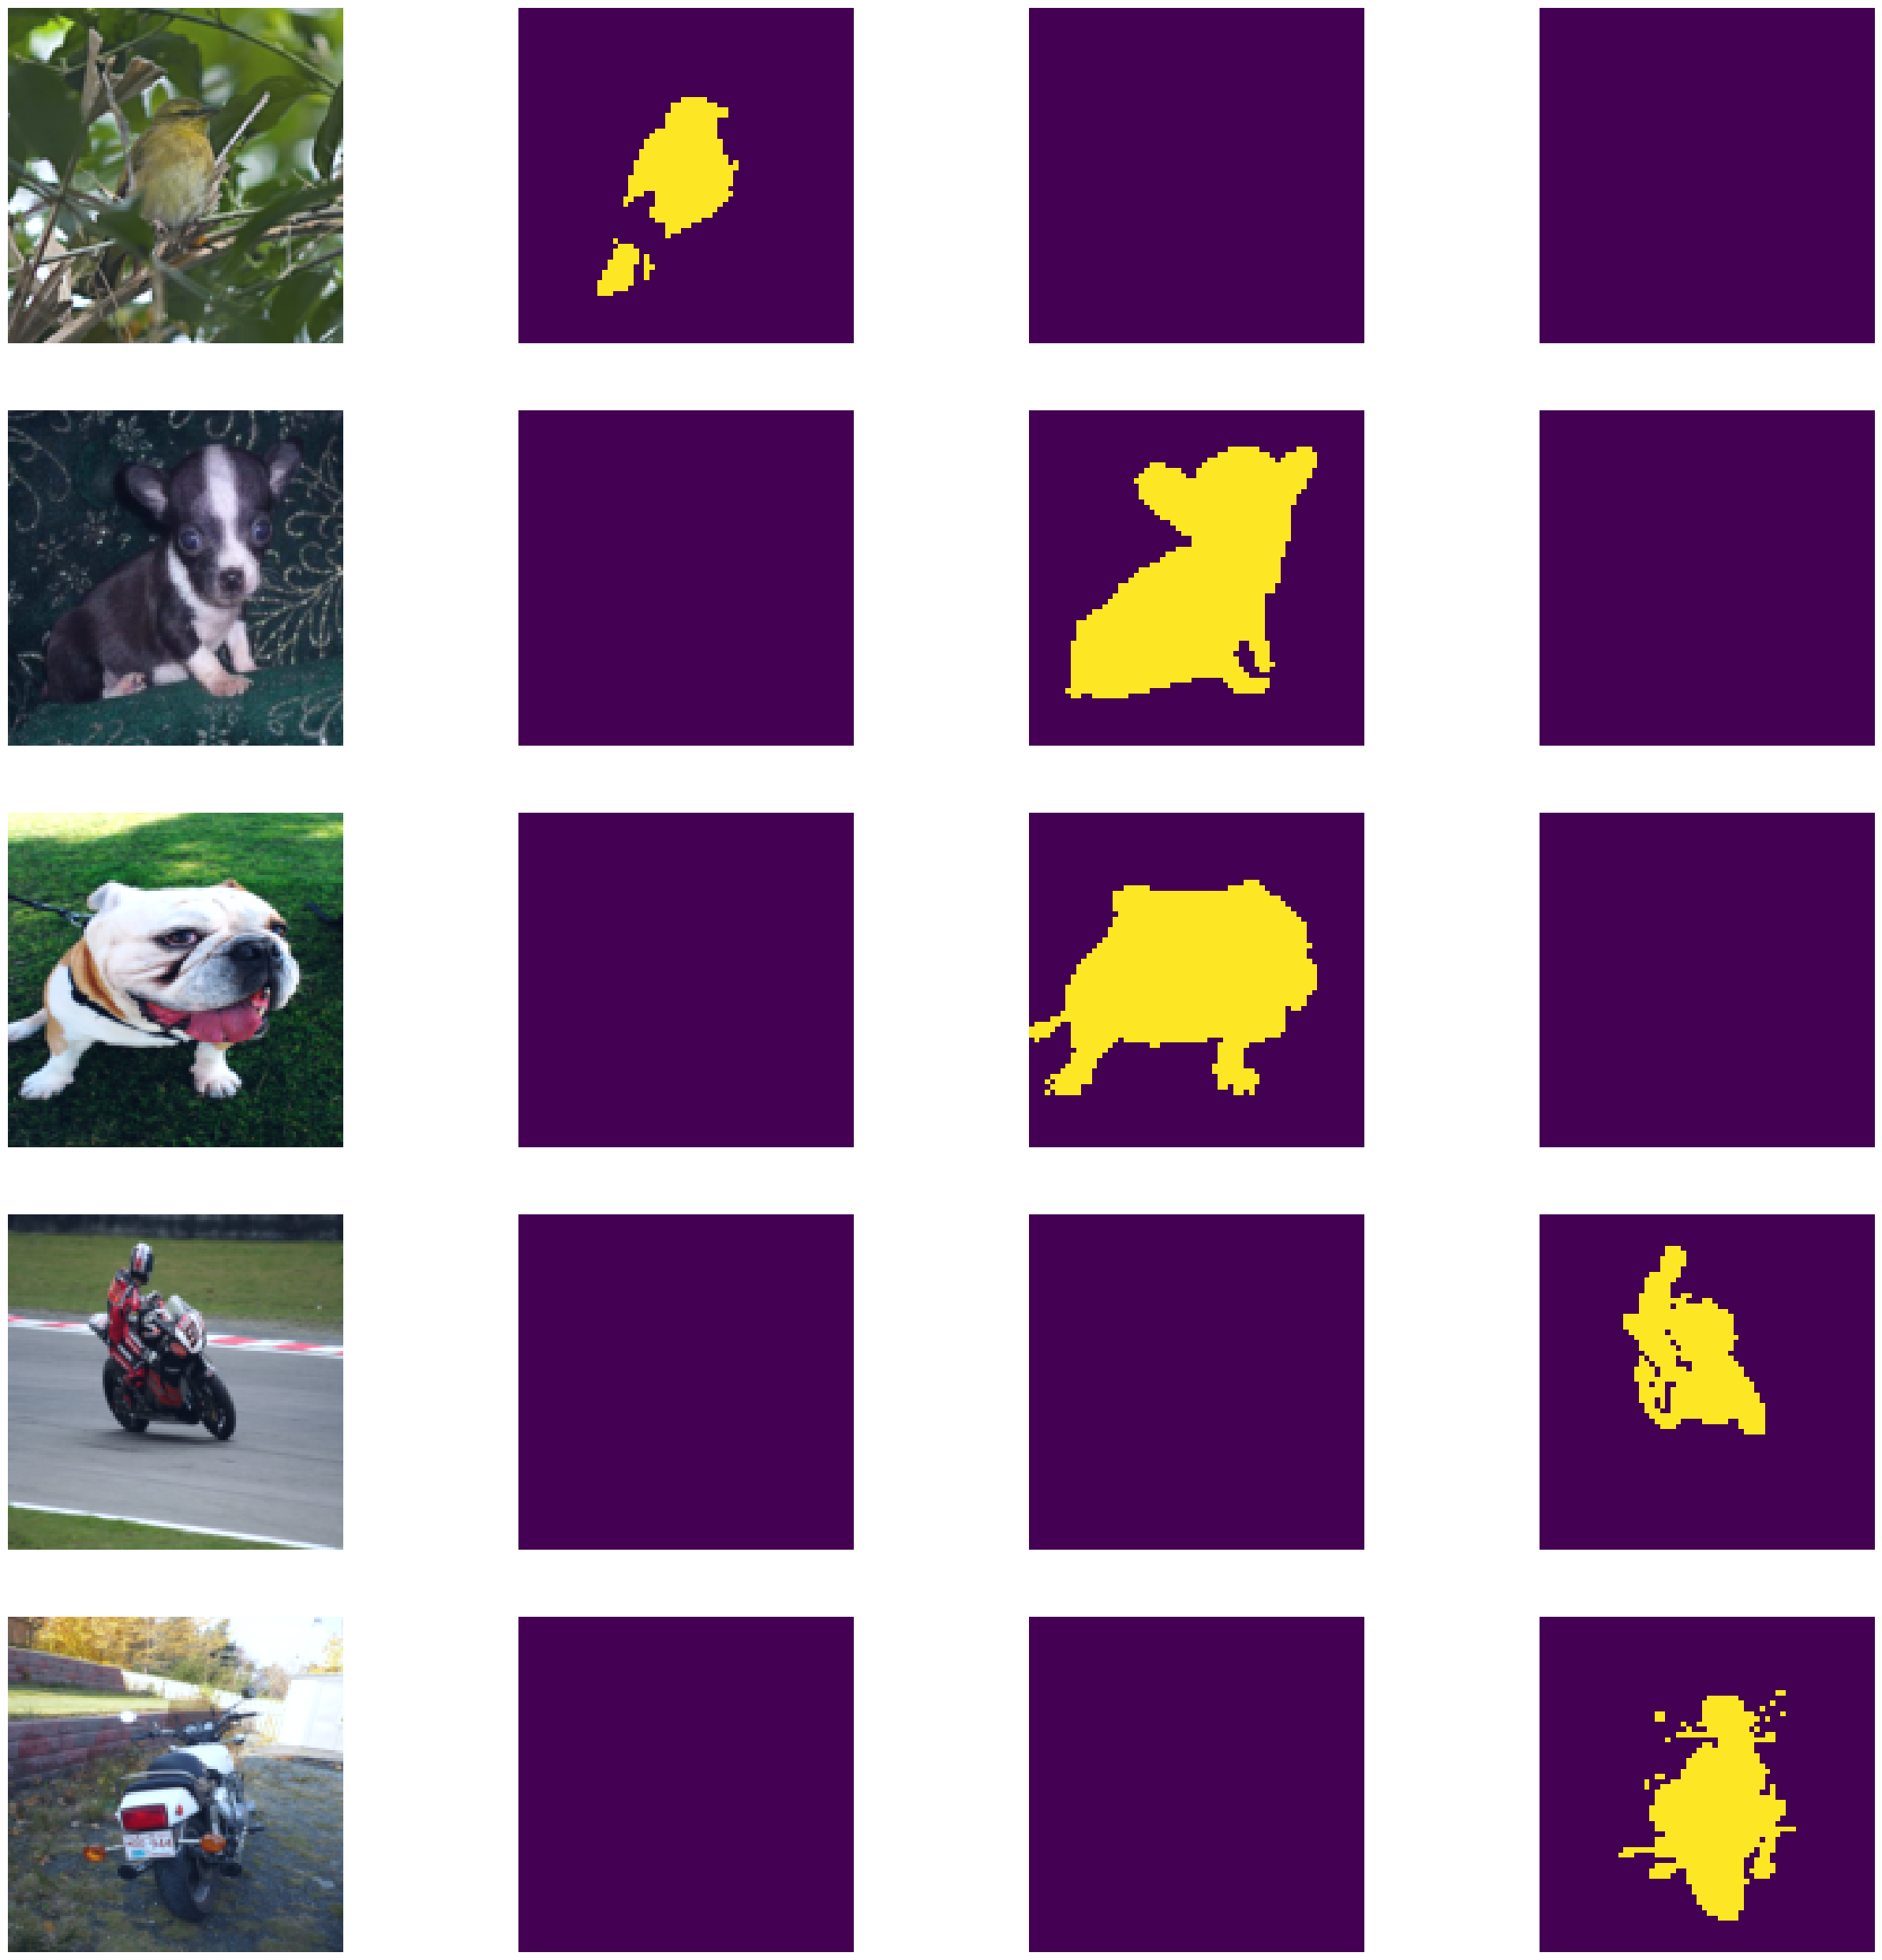

In [ ]:
visualize_data(images[:5], masks[:5])

## Model Implementation - 2 points


### Backbone preparation
Here, you will download the EfficientNet model and create classes that will allow you to extract features from the downloaded model. By features, we mean outputs of specified layers.

### EfficientNet Feature Extraction
First, let's download and inspect the model.

In [ ]:
def get_efficient_net():
    return torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

def get_example_input():
    return torch.rand(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH) # [B, C, H, W]

efficient_net = get_efficient_net()
print(torchinfo.summary(efficient_net, input_size=(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)))
print(efficient_net)

In [ ]:
def get_efficient_net():
    return torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

def get_example_input():
    return torch.rand(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH) # [B, C, H, W]

efficient_net = get_efficient_net()
print(torchinfo.summary(efficient_net, input_size=(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)))
print(efficient_net)

Fill in the code below according to the docstrings.  
There are several approaches to the task below one of them is to use `register_forward_hook`.  
The other one is to replace selected modules with appropriate wrappers.

In [ ]:
class EffNetFeatureExtractor(torch.nn.Module):
    """
    Accepts an efficient_net and an list of layers for feature extraction (feature_layer_ids).
    When called returns a list containing the outputs of the selected layers.
    The parameter feature_layer_ids specifies the ids of the layers from
    efficient_net.layers.
    To be more precise for feature_layer_ids = [4, 6] it returns a list containing outputs of
    self.efficient_net.layers[4] and self.efficient_net.layers[6].
    """

    def __init__(
        self, efficient_net, feature_layer_ids: List[int]
    ) -> None:
        super().__init__()

        self.efficient_net = efficient_net
        self.feature_layer_ids = feature_layer_ids

        ## TODO {

        ## }

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:

        ## TODO {

        ## }
        return extracted_features


def get_extracted_feature_shapes(net: EffNetFeatureExtractor):
    extracted_features = net(get_example_input())
    extracted_feature_shapes = [ef.shape for ef in extracted_features]
    return extracted_feature_shapes


##### TESTS START #####


def test_feature_extraction():
    efficient_net = get_efficient_net()
    net = EffNetFeatureExtractor(
        efficient_net=efficient_net, feature_layer_ids=[i for i in range(0, 7, 2)]
    )
    extracted_feature_shapes = get_extracted_feature_shapes(net)
    extracted_feature_shapes = get_extracted_feature_shapes(net) # this is on purpose

    expected_feature_shapes = [
        (1, 16, 64, 64),
        (1, 40, 16, 16),
        (1, 112, 8, 8),
        (1, 320, 4, 4),
    ]
    assert len(extracted_feature_shapes) == len(expected_feature_shapes)
    for extracted_fs, expected_fs in zip(
        extracted_feature_shapes, expected_feature_shapes
    ):
        assert extracted_fs == expected_fs


test_feature_extraction()

#####  TESTS END  #####

### Feature extractor for the Resnet50 backbone

Implement analogous feature extractor as above , but for the ResNet50 backbone.

In [ ]:
class ResNet50FeatureExtractor(torch.nn.Module):
## TODO {

## }

Extra: implement the parent FeatureExtractor interface class (from which EffNetFeatureExtractor and ResNet50FeatureExtractor inherit)

In [ ]:
class FeatureExtractor():
## TODO {

## }

### Feature Channel Matching
In BiFPN we want all features to have the same number of channels (so we can add them easily).  
Complete the code below according to docstrings.  
`MatchChannels` is already implemented.

In [ ]:
class MatchChannels(torch.nn.Module):
    """
    Given the input of shape (BATCH, in_channels, H, W),
    converts it to the one of shape (BATCH, out_channels, H, W)
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert len(x.shape) == 4
        x = self.conv(x)
        x = self.bn(x)
        return x


class EffNetBackboneWrapper(torch.nn.Module):
    """
    Given a efficient net backbone and channel_matching_fn (a function of form lambda x: MatchChannels(x, c))
    runs backbone to extract the features and uses modules created using channel_matching_fn to
    make channel dimension equal in all features.

    It also freezes the parameters of the backbone so that they do not receive gradients.
    """

    def __init__(self, backbone: FeatureExtractor, channel_matching_fn):
        super().__init__()
        self.backbone = backbone

        ## TODO {

        ## }

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:

        ## TODO {

        ## }

        return channel_matched_features

##the same backbone wrapper for the other Resnet50 backbone
class Resnet50BackboneWrapper(torch.nn.Module):
## TODO {

## }

##### TESTS START #####


def test_backbone_basic():
    efficient_net = get_efficient_net()
    net = EffNetFeatureExtractor(
        efficient_net=efficient_net, feature_layer_ids=[i for i in range(0, 7, 2)]
    )

    wrapped = BackboneWrapper(
        backbone=net, channel_matching_fn=lambda x: MatchChannels(x, 24)
    )

    out = wrapped(get_example_input())

    out_shapes = [feature.shape for feature in out]

    expected_feature_shapes = [
        (1, 24, 64, 64),
        (1, 24, 16, 16),
        (1, 24, 8, 8),
        (1, 24, 4, 4),
    ]
    assert len(out_shapes) == len(expected_feature_shapes)
    for extracted_fs, expected_fs in zip(out_shapes, expected_feature_shapes):
        assert extracted_fs == expected_fs


def test_backbone_gradients():

    efficient_net = get_efficient_net()
    net = EffNetFeatureExtractor(
        efficient_net=efficient_net, feature_layer_ids=[i for i in range(0, 7, 2)]
    )

    wrapped = BackboneWrapper(
        backbone=net, channel_matching_fn=lambda x: MatchChannels(x, 24)
    )

    out = wrapped(get_example_input())

    sum = 0.0
    for feature in out:
        sum += feature.sum()

    sum.backward()

    backbone_parameter_names = set(
        [f"backbone.{name}" for name, _ in wrapped.backbone.named_parameters()]
    )
    contains_trainable_param = False
    for name, param in wrapped.named_parameters():
        if name in backbone_parameter_names:
            assert param.grad is None
        else:
            assert param.grad is not None
            contains_trainable_param = True
    assert contains_trainable_param


test_backbone_basic()
test_backbone_gradients()
#####  TESTS END  #####

### BiFPN - Feature Fusion
Now we will implement the BiFPN network. Starting with single-way feature fusion, and then stacked multiple.   
Complete the code below according to docstrings.

In [ ]:
class BiFPNSingle(torch.nn.Module):
    """
    Given list of height features (list of length height),
    with each feature having feature_channels channels
    (that is i'th feature has shape (BATCH, feature_channels, H_i, W_i))
    performs the following sequence of operations
    res[0] = feature_list[0]
    res[i] = ACT(BN(CONVS(w[i][1] * feature_list[i] + w[i][2]*RESIZE(res[i-1]) + w[i][3]*aux_feature_list[i])))
    where the part w[i][3]*aux_feature_list[i] is present only when aux_feature_list is not None
    and weights w are calculated like in the BiFPN paper.
    Choice of CONVS is not specified."""

    def __init__(self, feature_channels: int, height: int) -> None:
        super().__init__()
        self.height = height
        self.weights = torch.nn.ParameterList([
            torch.nn.Parameter(torch.ones(3, dtype=torch.float32))
            for _ in range(height - 1)
        ])
        self.convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(feature_channels, feature_channels, kernel_size=3, padding=1),
                torch.nn.BatchNorm2d(feature_channels),
                torch.nn.ReLU()
            )
            for _ in range(height - 1)
        ])

    def normalize_weights(self, weights: torch.Tensor):
        """
        Makes weights "add up to one", uses either softmax or the
        method from the BiFPN paper.
        """
        weights = weights + 1e-4  # Add a small epsilon to avoid division by zero
        weights = weights / torch.sum(weights)
        return weights

    def forward(
        self,
        feature_list: List[torch.Tensor],
        aux_feature_list: Optional[List[torch.Tensor]] = None,
    ) -> List[torch.Tensor]:
        ## TODO {

        ## }

        return result




##### TESTS START #####


def test_bifpn_single():

    bifpn_single = BiFPNSingle(32, 3)

    input_data = [
        torch.randn(1, 32, 64, 64),
        torch.randn(1, 32, 32, 32),
        torch.randn(1, 32, 7, 7),
    ]

    out = bifpn_single(input_data)

    assert len(out) == len(input_data)
    for o, i in zip(out, input_data):
        print(o.shape == i.shape)
        assert o.shape == i.shape


test_bifpn_single()
#####  TESTS END  #####

In [ ]:
class BiFPN(torch.nn.Module):
    """
    Uses several BiFPNSingle modules (num_repeats) to implement a BiFPN module as in the BiFPN paper.
    """
    def __init__(self, in_channels_list, out_channels, num_repeats):
    ## TODO {

    ## }


##### TESTS START #####


def test_bifpn():

    bifpn_single = BiFPN(32, 3)

    input_data = [
        torch.randn(1, 32, 64, 64),
        torch.randn(1, 32, 32, 32),
        torch.randn(1, 32, 7, 7),
    ]

    out = bifpn_single(input_data)

    assert len(out) == len(input_data)
    for o, i in zip(out, input_data):
        assert o.shape == i.shape


test_bifpn_single()
#####  TESTS END  #####

### Segmentation Head

In [ ]:
class SegmentationHead(torch.nn.Module):
    """
    Given an input of shape (B, feature_channels, H, W)
    Produces the output of shape (B, num_classes, H', W') (where H', W' = output_shape)
    consisting of logits (that is no activation in the last layer) that can be used to classify each pixel.
    To do so uses additional convolution(s) that operate on input with inner_channels channels.
    """

    def __init__(
        self,
        feature_channels: int,
        output_shape: Tuple[int, int] = (PREDICTION_HEIGHT, PREDICTION_WIDTH),
        inner_channels: int = 64,
        num_classes: int = 20,
    ):
        super().__init__()
        self.output_shape = output_shape
        self.num_classes = num_classes
        ## TODO {

        ## }

    def forward(self, x):
        ## TODO {

        ## }

        assert result.shape[0] == x.shape[0]
        assert result.shape[1] == self.num_classes
        assert result.shape[2:] == self.output_shape
        return result

### Network

In [ ]:
class Net(torch.nn.Module):
    """
    input parameters (defaults provided):
    * num_repeats - nr# of BiFPNSingle modules,
    * backbone - either 'efficientnet' or 'resnet50'

    Given an input of shape (BATCH, 3, H, W)
    returns a tensor of shape (BATCH, #CLASS, H', W') (where H', W' = output_shape)
    """

    def __init__(
        self,
        num_repeats = 1,
        backbone = 'efficientnet',
        feature_channels: int = 32,
        output_shape: Tuple[int, int] = (PREDICTION_HEIGHT, PREDICTION_WIDTH),
        feature_layer_ids: List[int] = [0, 1, 2, 3, 4, 5, 6],
    ) -> None:
        super().__init__()

        ## TODO {

        ## }

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ## TODO {

        ## }
        return result

## Training and Evaluation - 3 points

### Metrics - 1 point

Implement four  metrics: accuracy  , mIoU (IoU for all classes at once), Frequency Weighted IoU.

In [ ]:
def accuracy(prediction: np.ndarray, ground_truth: np.ndarray) -> np.ndarray:
    assert len(prediction.shape) == 4
    assert prediction.shape == ground_truth.shape
    assert np.logical_or(prediction == 1, prediction == 0).all()
    assert np.logical_or(ground_truth == 1, ground_truth == 0).all()

    ## TODO {

    ## }

    assert result.shape == prediction.shape[:2]
    return result


##### TESTS START #####
def test_accuracy():
    a = np.zeros((1, 1, 64, 64))
    a[:, :, 32:48, 32:48] = 1
    b = np.zeros((1, 1, 64, 64))
    b[:, :, 47:63, 47:63] = 1
    assert np.isclose(
        accuracy(np.concatenate([a, a], axis=1), np.concatenate([a, b], axis=1)),
        np.array([1.0, (4096 - 510) / 4096])[None, :],
    ).all()


test_accuracy()
#####  TESTS END  #####

In [ ]:
def miou_metric(prediction: np.ndarray, ground_truth: np.ndarray):

    ## TODO {

    ## }



In [ ]:
def frequency_weighted_iou(prediction: np.ndarray, ground_truth: np.ndarray):
## TODO {

## }

### Eval Loop - 1point

In [ ]:

DEVICE = torch.device("cuda")
def one_hot_encode_prediction(predictions: torch.Tensor) -> torch.Tensor:
    """
    Given predictions of shape (B, H, W)
    one hot encodes it as
    single tensor of shape (B, #CLASS, H, W), such that
    element (b, c, h, w) is 1 if pixel corresponds
    to class c and 0 otherwise.
    """

    assert len(predictions.shape) == 3

    predictions_oh = torch.nn.functional.one_hot(predictions, num_classes=3)
    predictions_oh = predictions_oh.permute(0, 3, 1, 2)  # B, C, H, W

    assert len(predictions_oh.shape) == 4
    assert predictions_oh.shape[1] == 3

    return predictions_oh

@torch.no_grad
def eval_fn(model, test_loader):
    model.eval()

    total = 0
    for data in test_loader:
        x, y = data
        ground_truth = one_hot_encode_prediction(y).cpu().numpy()
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = model(x)
        prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)
        prediction = one_hot_encode_prediction(prediction).cpu().numpy()

        #collect accuracy  , mIoU, Frequency Weighted IoU
        ## TODO {

        ## }

        total += prediction.shape[0]


#collect accuracy  , mIoU, Frequency Weighted IoU
#print metrics for all classes
## TODO {

## }

### Train Loop - 1 point

Complete the two training loops using the Net constructor with default values.
Use `CrossEntropyLoss` and the Dice loss .


In [ ]:
def train_crossentropy(
    model,
    optimizer,
    train_loader,
    test_loader,
    num_epoch,
    eval_fn,
    weight=torch.tensor([1.0, 1.0, 1.0], device=DEVICE),
):
    ## TODO {

    ## }

def train_dice(
    model,
    optimizer,
    train_loader,
    test_loader,
    num_epoch,
    eval_fn,
    weight=torch.tensor([1.0, 1.0, 1.0], device=DEVICE),
):
    ## TODO {

    ## }

In [ ]:
def create_model_and_optimizer():
    model = Net()
    model.to(DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters())
    return model, optimizer


model, optimizer = create_model_and_optimizer()
train_crossentropy(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

In [ ]:
model, optimizer = create_model_and_optimizer()
train_dice(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

## Inspection and Ablations - 5 points


First let's inspect the masks generated by the model.


In [ ]:
samples = next(iter(TEST_LOADER))
images, masks = samples

with torch.no_grad():
    pred = model(images.to(DEVICE))
    pred = torch.argmax(pred, dim=-3).cpu()


visualize_data(images[:5], pred[:5])

### Best and Worst Predictions - 2 point
Visualize the best and worst prediction made by the model on the test set (according to the accuracy metric) per each class in the dataset.
Compare them with ground truths. Do you notice any problems? If you notice problems then how can they be addressed?

In [ ]:

## TODO {
# CODE

##}

## TODO {
# Answer

## }



### Ablations  - 3 points

train several instances for semantic segmentation, ablate with respect to:

1. Backbone: EfficientNet and Resnet50

2. different number of BiFPNSingle modules (num_repeats = 2, 3),

3. Training Loss CrossEntropy and Dice

Perform **8** experiments in total.

Identify the configuration achieving the highest mIoU metric for all classess simultaneously.

In [ ]:
## TODO {
# CODE

##}

## TODO {
# Answer

## }
